In [ ]:
!pip install gymnasium

In [16]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
# Example render
env = gym.make('CartPole-v1', render_mode='human')

for episode in range(10):
    done = False
    env.reset()
    while not done:
        _, _, done, __annotations__, _ = env.step(env.action_space.sample()) # take a random action
    
env.close()


In [17]:
# Hyperparameters
learning_rate = 0.001
gamma         = 0.98
layer_size    = 64

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(4, layer_size)
        self.fc2 = nn.Linear(layer_size, 2)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.to(device)

        print(f"Number of parameters: {sum(p.numel() for p in self.parameters())}")

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x
      
    def put_data(self, item):
        self.data.append(item)
        
    def train_net(self):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + gamma * R
            loss = -torch.log(prob) * R
            loss.backward()
        self.optimizer.step()
        self.data = []

Using device: cpu


In [18]:
# Define the environment and the model
env = gym.make('CartPole-v1')
model = Policy()

Number of parameters: 450


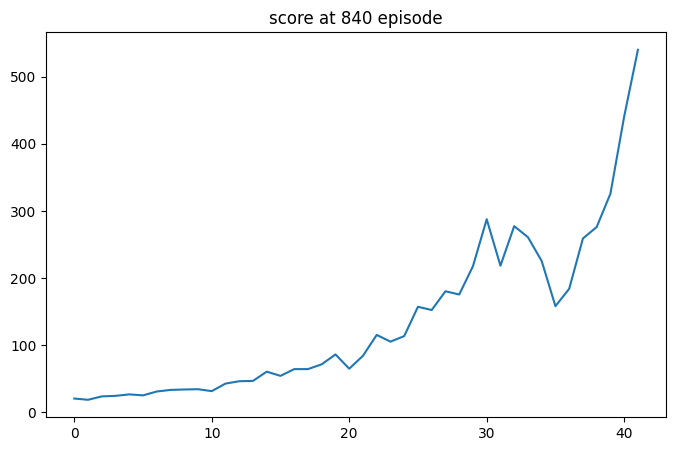

Clear at 840 episode
Training complete at 840 episode


In [19]:
# Training
score_log = []
score = 0.0
print_interval = 20


for n_epi in range(10000):
    s, _ = env.reset()
    done = False
    
    while not done:
        s = torch.tensor(s, dtype=torch.float32, device=device)
        prob = model(s)
        m = Categorical(prob)
        a = m.sample()
        s_prime, r, done, truncated, info = env.step(a.item())
        model.put_data((r,prob[a]))
        s = s_prime
        score += r
        
    model.train_net()
    
    if n_epi%print_interval==0 and n_epi!=0:
        score_log.append(score/print_interval)
        score = 0.0
        
        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.plot(score_log)
        plt.title(f'score at {n_epi} episode')
        plt.show()

        if score_log[-1] > 300:
            print(f"Clear at {n_epi} episode")
            torch.save(model.state_dict(), 'cartpole_policy.pth')
        if score_log[-1] > 500:
            print(f"Training complete at {n_epi} episode")
            break
        
env.close()

In [ ]:
# Evaluation
def evaluate(model, env, episodes=3):
    total_score = 0
    device = model.fc1.weight.device
    for i in range(episodes):
        s, _ = env.reset()
        done = False
        score = 0
        while not done:
            s = torch.tensor(s, dtype=torch.float32, device=device)
            prob = model(s)
            a = torch.argmax(prob).item()
            s_prime, r, done, truncated, info = env.step(a)
            score += r
            s = s_prime
        print(f"Episode {i+1}: Score = {score}")
        total_score += score
    print(f"Average Score over {episodes} episodes: {total_score / episodes}")

if __name__ == '__main__':
    env = gym.make('CartPole-v1', render_mode='human')
    model = Policy()
    model.load_state_dict(torch.load('cartpole_policy.pth'))
    model.eval()

    evaluate(model, env)
    env.close()